In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 1s 9us/step


In [10]:
# 正規化
# 中央値を引いて、標準偏差で割る
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# 訓練データを使って正規化する
test_data -= mean
test_data /= std

In [11]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) # 活性化関数は適用されず、線形になる（スカラー回帰）
    model.compile(
        optimizer='rmsprop',
        loss='mse', # 損失関数：平均二乗誤差
        metrics=['mae'] # 評価関数：平均絶対誤差
    )
    return model

In [23]:
import numpy as np

k = 4
num_val_samples = len(train_data) // 4
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [
            train_data[: i * num_val_samples],
            train_data[(i + 1) * num_val_samples:]
        ]
        , axis=0
    )
    partial_train_targets = np.concatenate(
        [
            train_targets[: i * num_val_samples],
            train_targets[(i + 1) * num_val_samples:]
        ]
        , axis=0
    )
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [24]:
all_scores

[2.214875872772519, 2.4381609151859096, 2.676574874632429, 2.3957258728471134]

In [25]:
np.mean(all_scores)

2.4313343838594927

In [26]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [
            train_data[: i * num_val_samples],
            train_data[(i + 1) * num_val_samples:]
        ]
        , axis=0
    )
    partial_train_targets = np.concatenate(
        [
            train_targets[: i * num_val_samples],
            train_targets[(i + 1) * num_val_samples:]
        ]
        , axis=0
    )
    model = build_model()
    history = model.fit(
        partial_train_data,
        partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs,
        batch_size=1,
        verbose=0
    )
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [27]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

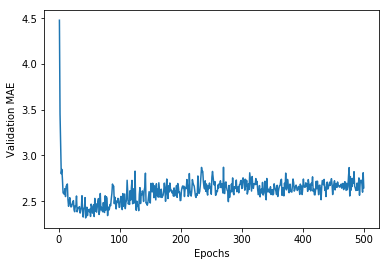

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

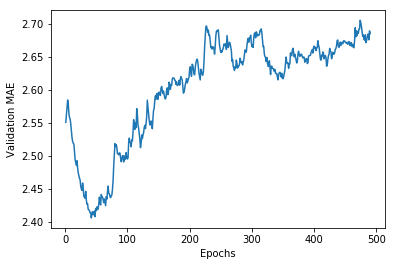

In [33]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [35]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

102/102 [==============================] - 0s 2ms/step


2.6405864696876677